## 以Networkx套件與Girvan Newman演算法找出利用好友系統洗點的FreeMyCard用戶

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx                         # NetworkX
from networkx.algorithms import community     # 社區發現演算法

pd.set_option("display.max_rows",1200)
%matplotlib notebook

In [2]:
friend = pd.read_table('friend.txt', encoding='utf8' ,names=['新手會員','新手地區','老手會員','老手地區','時間'])

In [3]:
friend.head()

,新手會員,新手地區,老手會員,老手地區,時間
0,104752806,TAIWAN,104183517,TAIWAN,2018-08-01 00:12:11.963
1,104752882,TAIWAN,102598239,TAIWAN,2018-08-01 06:05:20.773
2,104752780,TAIWAN,100943206,MALAYSIA,2018-08-01 07:26:15.273
3,104752902,TAIWAN,104373753,TAIWAN,2018-08-01 07:28:19.207
4,104752906,TAIWAN,102051349,TAIWAN,2018-08-01 07:39:24.550


In [4]:
friend['新手會員'].duplicated().value_counts()

False    777
Name: 新手會員, dtype: int64

In [5]:
friend['老手會員'].duplicated().value_counts()

True     421
False    356
Name: 老手會員, dtype: int64

### Social Network Analysis

In [6]:
# 建立 Graph

G = nx.Graph()
G = nx.from_pandas_edgelist(friend, '新手會員', '老手會員')

In [7]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1103
Number of edges: 777
Average degree:   1.4089


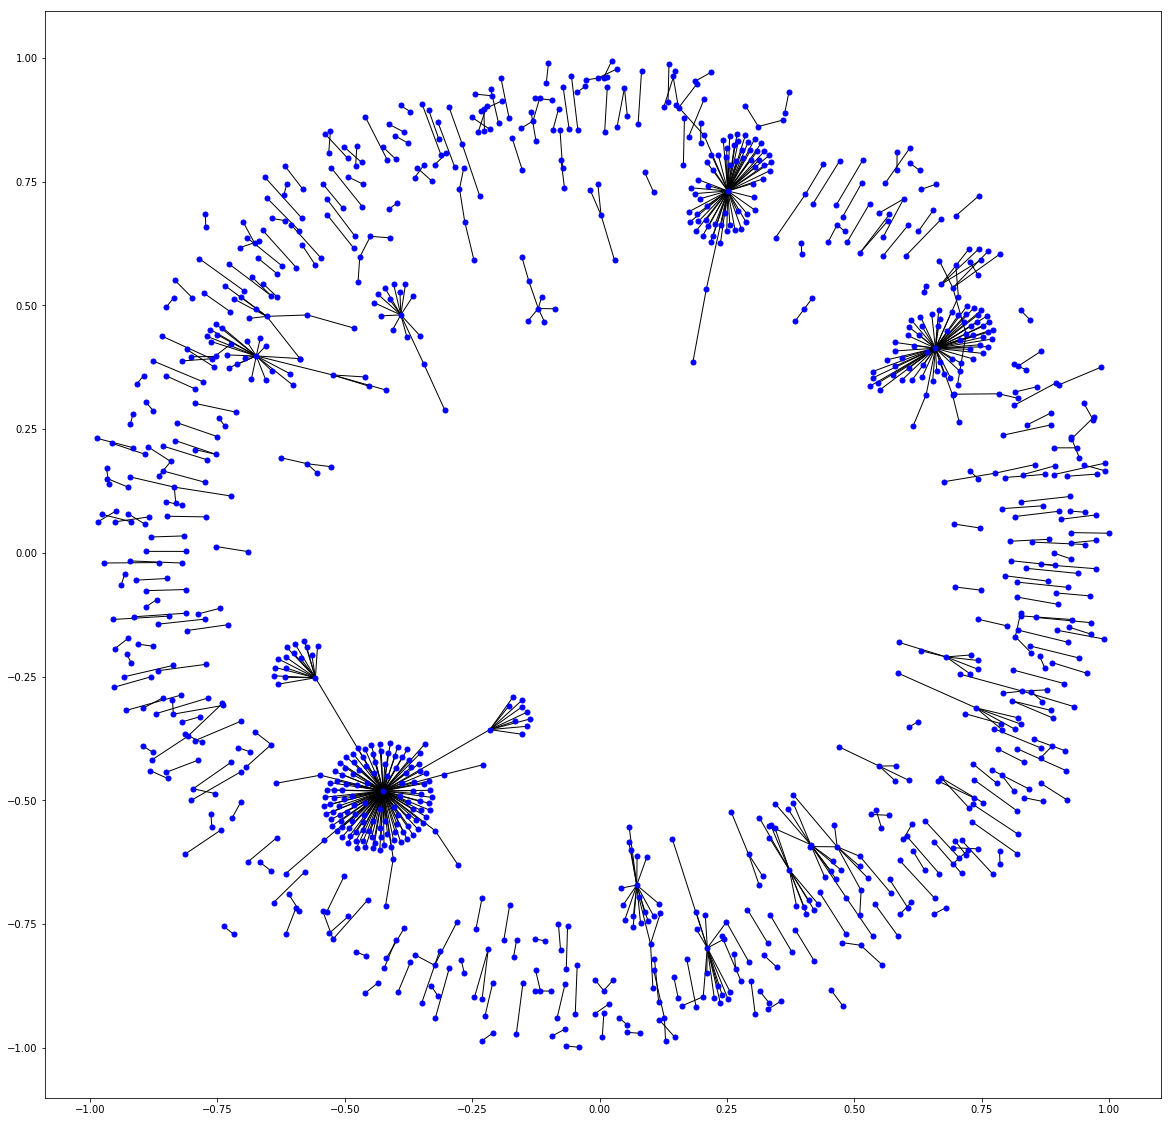

In [8]:
# 視覺化

plt.figure(figsize=(20, 20))

pos=nx.spring_layout(G,k=0.07)

nx.draw_networkx(G,pos,with_labels=None,node_size=25, node_color='blue')
plt.show()


### Centrality

In [9]:
degree_centrality = nx.degree_centrality(G)
centra = list(degree_centrality.items())

df_degree_centrality = pd.DataFrame(centra, columns=['SN', 'centrality'])
df_degree_centrality = df_degree_centrality.sort_values(by='centrality', ascending=False)  # 排序
df_degree_centrality.head()

,SN,centrality
1,104183517,0.114338
22,103828535,0.058076
16,100041407,0.056261
5,100943206,0.018149
733,104768186,0.014519


In [10]:
# nx.set_node_attributes(G, degree_centrality, 'centrality')   # 將中心性加到G的屬性(degree_centrality是dict)

### Community Algorithms

In [11]:
# Girvan Newman

communities_generator = community.girvan_newman(G)

next_level_communities = next(communities_generator)

# sorted(next_level_communities)

In [12]:
# 將分群結果換為 DataFrame 以利之後繪圖

data = [[element, "Group{}".format(ii + 1)] for ii, st in enumerate(next_level_communities) for element in sorted(st)] #?

df_GN = pd.DataFrame(data=data, columns=['SN', 'Group'])
df_GN.head()

,SN,Group
0,104183517,Group1
1,104748347,Group1
2,104748399,Group1
3,104752806,Group1
4,104753044,Group1


In [13]:
# 將新劃分的社群做編碼

carac = df_GN.set_index('SN')
carac = carac.reindex(G.nodes())
carac['Group'] = pd.Categorical(carac['Group'])
color = carac['Group'].cat.codes

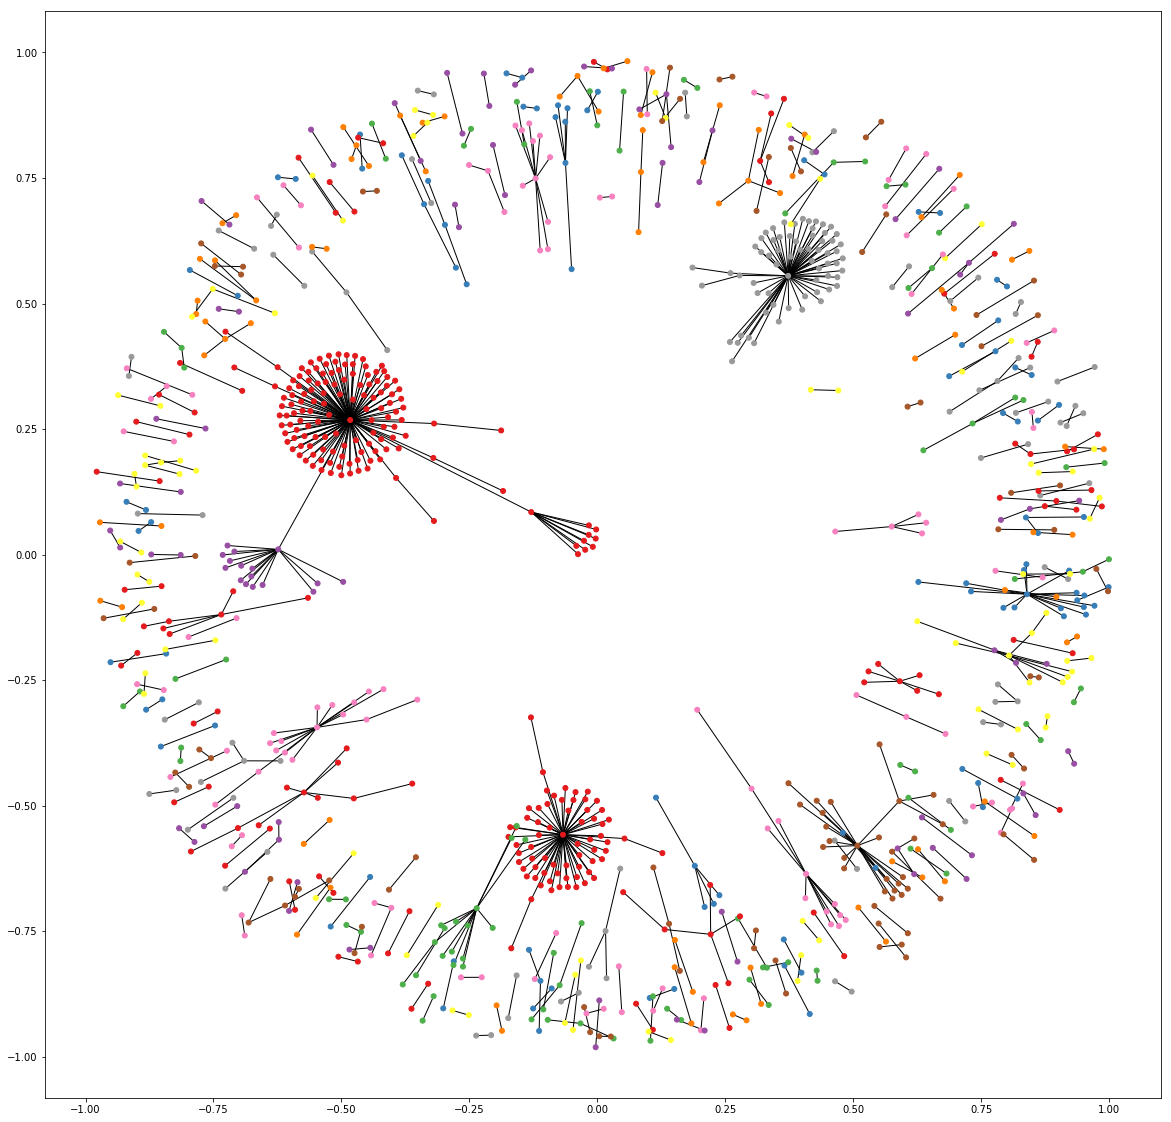

In [38]:
# 視覺化

plt.figure(figsize=(20, 20))
pos=nx.spring_layout(G,k=0.08)

nx.draw_networkx(G,pos,with_labels=None,node_size=25, node_color=color, cmap=plt.cm.Set1)
plt.show()

In [15]:
# GN演算法認為紫色和紅色為不同的社群

### 整理

In [16]:
list1 = sorted(map(sorted, next_level_communities))          # GN分的社群

list2 = sorted(list1, key=lambda x: len(x), reverse=True)    # 依照元素多寡排序*

list3 = [len(i) for i in list2]                              # 列出各社群大小


In [17]:
N = np.mean(list3)+2*np.std(list3)
N

22.038166112042454

In [18]:
list4 = [i for i in list1 if len(i) > N ]             # 以平均社群大小(洗點帳戶數量)加兩個標準差為判斷是否為機器人標準
list5 = [i for i in list1 if len(i) <= N ]

In [19]:
robot = [i for x in list4 for i in x]                 # 疑似機器人名單(將社群拆掉)

main_robot = [i for x in list4 for i in x[0:1] ]      # 機器人主帳 (GN社群中心性最高者)

sep_robot = list(set(robot) - set(main_robot))        # 機器人分身 

human = [i for x in list5 for i in x]                 # 真實用戶

In [20]:
# robot

In [21]:
main_robot

[100041407, 100943206, 103828535, 104183517]

In [22]:
# 1為疑似機器人分身  2為疑似機器人主帳  0為真實用戶

R = pd.DataFrame(sep_robot,columns=['SN'])
R['SNA'] = 1

MR = pd.DataFrame(main_robot,columns=['SN'])
MR['SNA'] = 2

H = pd.DataFrame(human,columns=['SN'])
H['SNA'] = 0

In [23]:
df_sna = pd.concat([R,MR,H])
df_sna.head()

,SN,SNA
0,104774657,1
1,104766473,1
2,104756233,1
3,104763406,1
4,104768529,1


In [24]:
df_all = pd.merge(df_sna, df_GN, how='outer' ,on='SN')
df_all.sample(5)

,SN,SNA,Group
82,104763704,1,Group11
582,102681531,0,Group184
645,104753452,0,Group15
41,104767651,1,Group3
621,104762180,0,Group134


In [25]:
df_all.SNA.value_counts()

0    806
1    293
2      4
Name: SNA, dtype: int64

### Connected Components

In [26]:
# 直接以是否有邊相連來分社群

connected_components = nx.connected_components(G)

In [27]:
nx.number_connected_components(G)

326

In [28]:
list6 = sorted(map(sorted, connected_components))

list7 = sorted(list6, key=lambda x: len(x), reverse=True)

list8 = [len(i) for i in list7]
# list8 = [len(i) for i in sorted(nx.connected_components(G), key=len, reverse=True)]

In [29]:
n = np.mean(list8)+2*np.std(list8)
n

23.49022732739126

In [30]:
list9 = [i for i in list6 if len(i) > n ]
list10 = [i for i in list6 if len(i) <= n ]